<font color="black" face="Times New Roman" size="6"><b> Import Libraries </b></font> 

In [1]:
import joblib
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import optuna
from optuna.trial import TrialState
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

<font color="black" face="Times New Roman" size="6"><b> Data Exploring and Preparing </b></font> 

<font color="black" face="Times New Roman" size="4"><b> Temperature </b></font> 

In [2]:
folder_path = r'G:\ml_projects\siedlce_air\2023_temp'

all_files = os.listdir(folder_path)

csv_files = [f for f in all_files if f.endswith('.csv')]

dfs = []

for csv_file in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    df_sample = pd.read_csv(file_path)
    dfs.append(df_sample)

df_2023_temp = pd.concat(dfs, ignore_index=True)

In [3]:
df_2023_temp

,category,minimum,maximum
0,1.6.2023,8,25.5
1,2.6.2023,4,22.5
2,3.6.2023,2,16.6
3,4.6.2023,2,20.5
4,5.6.2023,4,22.9
...,...,...,...
237,27.1.2023,-2,0.3
238,28.1.2023,-2,-0.2
239,29.1.2023,-2,-0.1
240,30.1.2023,-1,1.2


In [4]:
df_2023_temp.rename(columns={'category': 'Data'}, inplace=True)

In [5]:
df_2023_temp['avg'] = (df_2023_temp['minimum'] + df_2023_temp['maximum']) / 2

df_2023_temp.drop(['minimum', 'maximum'], axis=1, inplace=True)

df_2023_temp

,Data,avg
0,1.6.2023,16.75
1,2.6.2023,13.25
2,3.6.2023,9.30
3,4.6.2023,11.25
4,5.6.2023,13.45
...,...,...
237,27.1.2023,-0.85
238,28.1.2023,-1.10
239,29.1.2023,-1.05
240,30.1.2023,0.10


In [6]:
df_2023_temp['Data'] = pd.to_datetime(df_2023_temp['Data'], format='%d.%m.%Y')
df_2023_temp = df_2023_temp.sort_values('Data')
df_2023_temp

,Data,avg
212,2023-01-01,14.35
213,2023-01-02,10.55
214,2023-01-03,7.25
215,2023-01-04,2.55
216,2023-01-05,4.50
...,...,...
207,2023-08-27,22.20
208,2023-08-28,20.55
209,2023-08-29,24.40
210,2023-08-30,20.25


In [7]:
all_range_time = pd.date_range(start=df_2023_temp['Data'].min(), end=df_2023_temp['Data'].max())

lost_time = all_range_time.difference(df_2023_temp['Data'])

print('Lost days in our data:', lost_time)

Lost days in our data: DatetimeIndex(['2023-01-20'], dtype='datetime64[ns]', freq=None)


<font color="black" face="Times New Roman" size="4"><b> Pollution PM2.5 </b></font> 

In [8]:
df_pm_25_2023 = pd.read_csv(r'G:\ml_projects\siedlce_air\pollution\gios-pjp-data_pm25_2023_01_08.csv')

In [9]:
df_pm_25_2023.head()

,Data,pollution PM2.5 [ug/m3]
2023-01-01 01:00,18.5,NaN
2023-01-01 02:00,9.2,NaN
2023-01-01 03:00,9.2,NaN
2023-01-01 04:00,9.8,NaN
2023-01-01 05:00,9.9,NaN


In [10]:
df_pm_25_2023.reset_index(inplace=True)
df_pm_25_2023.head()

,index,Data,pollution PM2.5 [ug/m3]
0,2023-01-01 01:00,18.5,NaN
1,2023-01-01 02:00,9.2,NaN
2,2023-01-01 03:00,9.2,NaN
3,2023-01-01 04:00,9.8,NaN
4,2023-01-01 05:00,9.9,NaN


In [11]:
pollution = df_pm_25_2023.columns[-1]
df_pm_25_2023 = df_pm_25_2023.drop(pollution, axis=1)
df_pm_25_2023.columns = ['Data', 'pollution PM2.5 [ug/m3]']

In [12]:
df_pm_25_2023.head()

,Data,pollution PM2.5 [ug/m3]
0,2023-01-01 01:00,18.5
1,2023-01-01 02:00,9.2
2,2023-01-01 03:00,9.2
3,2023-01-01 04:00,9.8
4,2023-01-01 05:00,9.9


In [13]:
df_pm_25_2023.shape

(5831, 2)

In [14]:
df_pm_25_2023['Data'] = pd.to_datetime(df_pm_25_2023['Data']) 

df_pm_25_2023['Data'] = df_pm_25_2023['Data'].dt.date

df_pm_25_2023 = df_pm_25_2023.groupby('Data').mean().reset_index()

In [15]:
df_pm_25_2023

,Data,pollution PM2.5 [ug/m3]
0,2023-01-01,9.447826
1,2023-01-02,15.154167
2,2023-01-03,11.125000
3,2023-01-04,15.800000
4,2023-01-05,4.766667
...,...,...
238,2023-08-27,12.491667
239,2023-08-28,7.204167
240,2023-08-29,9.166667
241,2023-08-30,7.320833


<font color="black" face="Times New Roman" size="4"><b> Pollution PM10 </b></font> 

In [16]:
df_pm_10_2023 = pd.read_csv(r'G:\ml_projects\siedlce_air\pollution\gios-pjp-data_pm_10_2023_01_08.csv')
df_pm_10_2023

,Data,pollution PM10 [ug/m3]
2023-01-01,12.5,NaN
2023-01-02,19.4,NaN
2023-01-03,14.0,NaN
2023-01-04,19.4,NaN
2023-01-05,4.8,NaN
...,...,...
2023-08-27,19.2,NaN
2023-08-28,9.6,NaN
2023-08-29,17.8,NaN
2023-08-30,11.0,NaN


In [17]:
df_pm_10_2023.reset_index(inplace=True)
df_pm_10_2023

,index,Data,pollution PM10 [ug/m3]
0,2023-01-01,12.5,NaN
1,2023-01-02,19.4,NaN
2,2023-01-03,14.0,NaN
3,2023-01-04,19.4,NaN
4,2023-01-05,4.8,NaN
...,...,...,...
238,2023-08-27,19.2,NaN
239,2023-08-28,9.6,NaN
240,2023-08-29,17.8,NaN
241,2023-08-30,11.0,NaN


In [18]:
pollution = df_pm_10_2023.columns[-1]
df_pm_10_2023 = df_pm_10_2023.drop(pollution, axis=1)
df_pm_10_2023.columns = ['Data', 'pollution PM10 [ug/m3]']
df_pm_10_2023

,Data,pollution PM10 [ug/m3]
0,2023-01-01,12.5
1,2023-01-02,19.4
2,2023-01-03,14.0
3,2023-01-04,19.4
4,2023-01-05,4.8
...,...,...
238,2023-08-27,19.2
239,2023-08-28,9.6
240,2023-08-29,17.8
241,2023-08-30,11.0


<font color="black" face="Times New Roman" size="2"><b> Creating Data Frame for analysis </b></font> 

In [19]:
df_pm_25_2023['Data'] = pd.to_datetime(df_pm_25_2023['Data'])
df_pm_10_2023['Data'] = pd.to_datetime(df_pm_10_2023['Data'])

In [20]:
df_pollution_2023 = pd.merge(df_pm_25_2023, df_pm_10_2023, on='Data', how='outer')
df_pollution_2023

,Data,pollution PM2.5 [ug/m3],pollution PM10 [ug/m3]
0,2023-01-01,9.447826,12.5
1,2023-01-02,15.154167,19.4
2,2023-01-03,11.125000,14.0
3,2023-01-04,15.800000,19.4
4,2023-01-05,4.766667,4.8
...,...,...,...
238,2023-08-27,12.491667,19.2
239,2023-08-28,7.204167,9.6
240,2023-08-29,9.166667,17.8
241,2023-08-30,7.320833,11.0


In [21]:
df_2023 = pd.merge(df_2023_temp, df_pollution_2023, on='Data', how='outer')
df_2023

,Data,avg,pollution PM2.5 [ug/m3],pollution PM10 [ug/m3]
0,2023-01-01,14.35,9.447826,12.5
1,2023-01-02,10.55,15.154167,19.4
2,2023-01-03,7.25,11.125000,14.0
3,2023-01-04,2.55,15.800000,19.4
4,2023-01-05,4.50,4.766667,4.8
...,...,...,...,...
238,2023-08-28,20.55,7.204167,9.6
239,2023-08-29,24.40,9.166667,17.8
240,2023-08-30,20.25,7.320833,11.0
241,2023-08-31,17.50,7.658333,12.1


<font color="black" face="Times New Roman" size="4"><b> Precipitation </b></font> 

In [22]:
folder_path = r'G:\ml_projects\siedlce_air\hydro_2023'

all_files = os.listdir(folder_path)

csv_files = [f for f in all_files if f.endswith('.csv')]

dfs = []

for csv_file in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    df_sample = pd.read_csv(file_path)
    dfs.append(df_sample)

df_2023_hydro = pd.concat(dfs, ignore_index=True)

In [23]:
df_2023_hydro.rename(columns={'category': 'Data'}, inplace=True)
df_2023_hydro.rename(columns={'Opady w mm': 'Precipitation [mm]'}, inplace=True)
df_2023_hydro['Data'] = pd.to_datetime(df_2023_hydro['Data'], format='%d.%m.%Y')
df_2023_hydro = df_2023_hydro.sort_values('Data')
df_2023_hydro

,Data,Precipitation [mm]
211,2023-01-01,0.0
212,2023-01-02,0.0
213,2023-01-03,0.0
214,2023-01-04,0.0
215,2023-01-05,6.9
...,...,...
206,2023-08-27,3.3
207,2023-08-28,0.0
208,2023-08-29,0.5
209,2023-08-30,12.7


<font color="black" face="Times New Roman" size="4"><b> Wind Speed </b></font> 

In [24]:
folder_path = r'G:\ml_projects\siedlce_air\wind_2023'

all_files = os.listdir(folder_path)

csv_files = [f for f in all_files if f.endswith('.csv')]

dfs = []

for csv_file in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    df_sample = pd.read_csv(file_path)
    dfs.append(df_sample)

df_2023_wind = pd.concat(dfs, ignore_index=True)
df_2023_wind

,category,Wiatr w m/s
0,1.6.2023,2.5
1,2.6.2023,2.5
2,3.6.2023,1.5
3,4.6.2023,1.2
4,5.6.2023,1.0
...,...,...
237,27.1.2023,1.0
238,28.1.2023,1.4
239,29.1.2023,3.8
240,30.1.2023,4.9


In [25]:
df_2023_wind.rename(columns={'category': 'Data'}, inplace=True)
df_2023_wind.rename(columns={'Wiatr w m/s': 'Wind [m/s]'}, inplace=True)
df_2023_wind['Data'] = pd.to_datetime(df_2023_wind['Data'], format='%d.%m.%Y')
df_2023_wind = df_2023_wind.sort_values('Data')
df_2023_wind

,Data,Wind [m/s]
212,2023-01-01,4.2
213,2023-01-02,2.8
214,2023-01-03,4.0
215,2023-01-04,3.6
216,2023-01-05,5.8
...,...,...
207,2023-08-27,1.4
208,2023-08-28,2.1
209,2023-08-29,2.1
210,2023-08-30,2.0


<font color="black" face="Times New Roman" size="2"><b> Add Wind Speed and Precipitation to df </b></font> 

In [26]:
df_2023 = pd.merge(df_2023, df_2023_hydro, on='Data', how='outer')
df_2023 = pd.merge(df_2023, df_2023_wind, on='Data', how='outer')
df_2023

,Data,avg,pollution PM2.5 [ug/m3],pollution PM10 [ug/m3],Precipitation [mm],Wind [m/s]
0,2023-01-01,14.35,9.447826,12.5,0.0,4.2
1,2023-01-02,10.55,15.154167,19.4,0.0,2.8
2,2023-01-03,7.25,11.125000,14.0,0.0,4.0
3,2023-01-04,2.55,15.800000,19.4,0.0,3.6
4,2023-01-05,4.50,4.766667,4.8,6.9,5.8
...,...,...,...,...,...,...
238,2023-08-28,20.55,7.204167,9.6,0.0,2.1
239,2023-08-29,24.40,9.166667,17.8,0.5,2.1
240,2023-08-30,20.25,7.320833,11.0,12.7,2.0
241,2023-08-31,17.50,7.658333,12.1,0.3,2.4


<font color="black" face="Times New Roman" size="4"><b> Creating Season, Free Days and Weekends  </b></font> 

In [27]:
def get_season(date):
    if (date.month == 12 and date.day >= 21) or (date.month == 1) or (date.month == 2) or (date.month == 3 and date.day < 21):
        return 'Winter'
    elif (date.month == 3 and date.day >= 21) or (date.month == 4) or (date.month == 5) or (date.month == 6 and date.day < 21):
        return 'Spring'
    elif (date.month == 6 and date.day >= 21) or (date.month == 7) or (date.month == 8) or (date.month == 9 and date.day < 23):
        return 'Summer'
    elif (date.month == 9 and date.day >= 23) or (date.month == 10) or (date.month == 11) or (date.month == 12 and date.day < 21):
        return 'Autumn'
df_2023['season'] = df_2023['Data'].apply(get_season)
df_2023

,Data,avg,pollution PM2.5 [ug/m3],pollution PM10 [ug/m3],Precipitation [mm],Wind [m/s],season
0,2023-01-01,14.35,9.447826,12.5,0.0,4.2,Winter
1,2023-01-02,10.55,15.154167,19.4,0.0,2.8,Winter
2,2023-01-03,7.25,11.125000,14.0,0.0,4.0,Winter
3,2023-01-04,2.55,15.800000,19.4,0.0,3.6,Winter
4,2023-01-05,4.50,4.766667,4.8,6.9,5.8,Winter
...,...,...,...,...,...,...,...
238,2023-08-28,20.55,7.204167,9.6,0.0,2.1,Summer
239,2023-08-29,24.40,9.166667,17.8,0.5,2.1,Summer
240,2023-08-30,20.25,7.320833,11.0,12.7,2.0,Summer
241,2023-08-31,17.50,7.658333,12.1,0.3,2.4,Summer


In [28]:
df_2023['Day'] = df_2023['Data'].dt.day_name()
df_2023['weekend'] = df_2023['Day'].isin(['Saturday', 'Sunday']).astype(int)
free_days = ['2023-01-01', '2023-01-06', '2023-04-09', '2023-04-10', '2023-05-01', '2023-05-03', '2023-06-08', '2023-08-15']
free_days = pd.to_datetime(free_days)
df_2023['free_day'] = df_2023['Data'].isin(free_days).astype(int)
df_2023['free_day_or_weekend'] = (df_2023['weekend'] | df_2023['free_day']).astype(int)

In [29]:
df_2023.drop(['Day', 'weekend', 'free_day'], axis=1, inplace=True)
df_2023

,Data,avg,pollution PM2.5 [ug/m3],pollution PM10 [ug/m3],Precipitation [mm],Wind [m/s],season,free_day_or_weekend
0,2023-01-01,14.35,9.447826,12.5,0.0,4.2,Winter,1
1,2023-01-02,10.55,15.154167,19.4,0.0,2.8,Winter,0
2,2023-01-03,7.25,11.125000,14.0,0.0,4.0,Winter,0
3,2023-01-04,2.55,15.800000,19.4,0.0,3.6,Winter,0
4,2023-01-05,4.50,4.766667,4.8,6.9,5.8,Winter,0
...,...,...,...,...,...,...,...,...
238,2023-08-28,20.55,7.204167,9.6,0.0,2.1,Summer,0
239,2023-08-29,24.40,9.166667,17.8,0.5,2.1,Summer,0
240,2023-08-30,20.25,7.320833,11.0,12.7,2.0,Summer,0
241,2023-08-31,17.50,7.658333,12.1,0.3,2.4,Summer,0


In [30]:
season_mapping = {
    'Winter': 0,
    'Spring': 1,
    'Summer': 2,
    'Autumn': 3
}
df_2023['season'] = df_2023['season'].map(season_mapping)
df_2023

,Data,avg,pollution PM2.5 [ug/m3],pollution PM10 [ug/m3],Precipitation [mm],Wind [m/s],season,free_day_or_weekend
0,2023-01-01,14.35,9.447826,12.5,0.0,4.2,0,1
1,2023-01-02,10.55,15.154167,19.4,0.0,2.8,0,0
2,2023-01-03,7.25,11.125000,14.0,0.0,4.0,0,0
3,2023-01-04,2.55,15.800000,19.4,0.0,3.6,0,0
4,2023-01-05,4.50,4.766667,4.8,6.9,5.8,0,0
...,...,...,...,...,...,...,...,...
238,2023-08-28,20.55,7.204167,9.6,0.0,2.1,2,0
239,2023-08-29,24.40,9.166667,17.8,0.5,2.1,2,0
240,2023-08-30,20.25,7.320833,11.0,12.7,2.0,2,0
241,2023-08-31,17.50,7.658333,12.1,0.3,2.4,2,0


<font color="black" face="Times New Roman" size="4"><b> Add Air Quality </b></font> 

In [31]:
df_2023['pollution PM10 [ug/m3]'] = pd.to_numeric(df_2023['pollution PM10 [ug/m3]'], errors='coerce')
def air_quality(pm10, pm25):
    quality_10 = ''
    quality_25 = ''
    
    if pm10 <= 20:
        quality_10 = 'Very Good'
    elif 20 < pm10 <= 50:
        quality_10 = 'Good'
    elif 50 < pm10 <= 80:
        quality_10 = 'Moderate'
    elif 80 < pm10 <= 110:
        quality_10 = 'Sufficient'
    elif 110 < pm10 <= 150:
        quality_10 = 'Poor'
    else:
        quality_10 = 'Very Poor'
        
    if pm25 <= 13:
        quality_25 = 'Very Good'
    elif 13 < pm25 <= 35:
        quality_25 = 'Good'
    elif 35 < pm25 <= 55:
        quality_25 = 'Moderate'
    elif 55 < pm25 <= 75:
        quality_25 = 'Sufficient'
    elif 75 < pm25 <= 110:
        quality_25 = 'Poor'
    else:
        quality_25 = 'Very Poor'
    
    quality_levels = ['Very Good', 'Good', 'Moderate', 'Sufficient', 'Poor', 'Very Poor']
    return quality_levels[max(quality_levels.index(quality_10), quality_levels.index(quality_25))]

df_2023['Air Quality'] = df_2023.apply(lambda row: air_quality(row['pollution PM10 [ug/m3]'], row['pollution PM2.5 [ug/m3]']), axis=1)
df_2023

,Data,avg,pollution PM2.5 [ug/m3],pollution PM10 [ug/m3],Precipitation [mm],Wind [m/s],season,free_day_or_weekend,Air Quality
0,2023-01-01,14.35,9.447826,12.5,0.0,4.2,0,1,Very Good
1,2023-01-02,10.55,15.154167,19.4,0.0,2.8,0,0,Good
2,2023-01-03,7.25,11.125000,14.0,0.0,4.0,0,0,Very Good
3,2023-01-04,2.55,15.800000,19.4,0.0,3.6,0,0,Good
4,2023-01-05,4.50,4.766667,4.8,6.9,5.8,0,0,Very Good
...,...,...,...,...,...,...,...,...,...
238,2023-08-28,20.55,7.204167,9.6,0.0,2.1,2,0,Very Good
239,2023-08-29,24.40,9.166667,17.8,0.5,2.1,2,0,Very Good
240,2023-08-30,20.25,7.320833,11.0,12.7,2.0,2,0,Very Good
241,2023-08-31,17.50,7.658333,12.1,0.3,2.4,2,0,Very Good


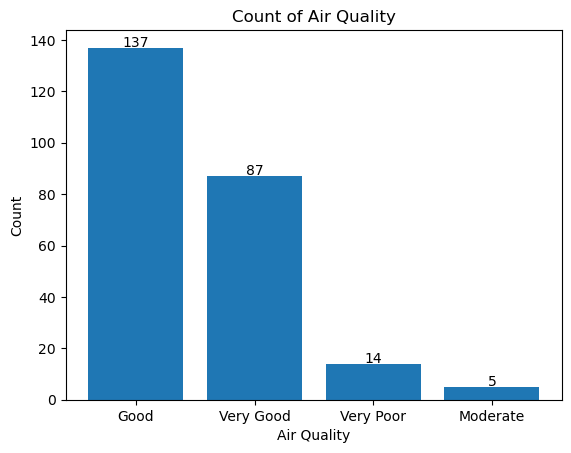

In [32]:
counts = df_2023['Air Quality'].value_counts()

plt.bar(counts.index, counts.values)
for index, value in enumerate(counts.values):
    plt.text(index, value + 0.5, str(value), ha='center')
plt.xlabel('Air Quality')
plt.ylabel('Count')
plt.title('Count of Air Quality')
plt.show()

In [33]:
quality_mapping = {
    'Very Good': 1,
    'Good': 2,
    'Moderate': 3,
    'Sufficient': 4,
    'Poor': 5,
    'Very Poor': 6
}
df_2023['Air Quality'] = df_2023['Air Quality'].replace(quality_mapping)
df_2023

,Data,avg,pollution PM2.5 [ug/m3],pollution PM10 [ug/m3],Precipitation [mm],Wind [m/s],season,free_day_or_weekend,Air Quality
0,2023-01-01,14.35,9.447826,12.5,0.0,4.2,0,1,1
1,2023-01-02,10.55,15.154167,19.4,0.0,2.8,0,0,2
2,2023-01-03,7.25,11.125000,14.0,0.0,4.0,0,0,1
3,2023-01-04,2.55,15.800000,19.4,0.0,3.6,0,0,2
4,2023-01-05,4.50,4.766667,4.8,6.9,5.8,0,0,1
...,...,...,...,...,...,...,...,...,...
238,2023-08-28,20.55,7.204167,9.6,0.0,2.1,2,0,1
239,2023-08-29,24.40,9.166667,17.8,0.5,2.1,2,0,1
240,2023-08-30,20.25,7.320833,11.0,12.7,2.0,2,0,1
241,2023-08-31,17.50,7.658333,12.1,0.3,2.4,2,0,1


In [34]:
df_2023.dropna(inplace=True)
df_2023

,Data,avg,pollution PM2.5 [ug/m3],pollution PM10 [ug/m3],Precipitation [mm],Wind [m/s],season,free_day_or_weekend,Air Quality
0,2023-01-01,14.35,9.447826,12.5,0.0,4.2,0,1,1
1,2023-01-02,10.55,15.154167,19.4,0.0,2.8,0,0,2
2,2023-01-03,7.25,11.125000,14.0,0.0,4.0,0,0,1
3,2023-01-04,2.55,15.800000,19.4,0.0,3.6,0,0,2
4,2023-01-05,4.50,4.766667,4.8,6.9,5.8,0,0,1
...,...,...,...,...,...,...,...,...,...
237,2023-08-27,22.20,12.491667,19.2,3.3,1.4,2,1,1
238,2023-08-28,20.55,7.204167,9.6,0.0,2.1,2,0,1
239,2023-08-29,24.40,9.166667,17.8,0.5,2.1,2,0,1
240,2023-08-30,20.25,7.320833,11.0,12.7,2.0,2,0,1


In [35]:
df_2023.rename(columns={'avg': 'Temp [C]'}, inplace=True)

In [36]:
col_to_move = df_2023.pop('Air Quality')
df_2023['Air Quality'] = col_to_move
col_to_move = df_2023.pop('pollution PM2.5 [ug/m3]')
df_2023['pollution PM2.5 [ug/m3]'] = col_to_move
col_to_move = df_2023.pop('pollution PM10 [ug/m3]')
df_2023['pollution PM10 [ug/m3]'] = col_to_move
df_2023

,Data,Temp [C],Precipitation [mm],Wind [m/s],season,free_day_or_weekend,Air Quality,pollution PM2.5 [ug/m3],pollution PM10 [ug/m3]
0,2023-01-01,14.35,0.0,4.2,0,1,1,9.447826,12.5
1,2023-01-02,10.55,0.0,2.8,0,0,2,15.154167,19.4
2,2023-01-03,7.25,0.0,4.0,0,0,1,11.125000,14.0
3,2023-01-04,2.55,0.0,3.6,0,0,2,15.800000,19.4
4,2023-01-05,4.50,6.9,5.8,0,0,1,4.766667,4.8
...,...,...,...,...,...,...,...,...,...
237,2023-08-27,22.20,3.3,1.4,2,1,1,12.491667,19.2
238,2023-08-28,20.55,0.0,2.1,2,0,1,7.204167,9.6
239,2023-08-29,24.40,0.5,2.1,2,0,1,9.166667,17.8
240,2023-08-30,20.25,12.7,2.0,2,0,1,7.320833,11.0


In [37]:
df_2023 = df_2023[['Data', 'Temp [C]', 'season', 'free_day_or_weekend', 'Precipitation [mm]', 'Wind [m/s]', 'Air Quality', 'pollution PM2.5 [ug/m3]', 'pollution PM10 [ug/m3]']]
df_2023

,Data,Temp [C],season,free_day_or_weekend,Precipitation [mm],Wind [m/s],Air Quality,pollution PM2.5 [ug/m3],pollution PM10 [ug/m3]
0,2023-01-01,14.35,0,1,0.0,4.2,1,9.447826,12.5
1,2023-01-02,10.55,0,0,0.0,2.8,2,15.154167,19.4
2,2023-01-03,7.25,0,0,0.0,4.0,1,11.125000,14.0
3,2023-01-04,2.55,0,0,0.0,3.6,2,15.800000,19.4
4,2023-01-05,4.50,0,0,6.9,5.8,1,4.766667,4.8
...,...,...,...,...,...,...,...,...,...
237,2023-08-27,22.20,2,1,3.3,1.4,1,12.491667,19.2
238,2023-08-28,20.55,2,0,0.0,2.1,1,7.204167,9.6
239,2023-08-29,24.40,2,0,0.5,2.1,1,9.166667,17.8
240,2023-08-30,20.25,2,0,12.7,2.0,1,7.320833,11.0


In [38]:
df_2023.rename(columns={'Precipitation [mm]': 'Precipitation[mm]', 'Wind [m/s]': 'Wind[m/s]', 'pollution PM2.5 [ug/m3]':'pollution air PM2.5 [ug/m3]'}, inplace=True)
df_2023

,Data,Temp [C],season,free_day_or_weekend,Precipitation[mm],Wind[m/s],Air Quality,pollution air PM2.5 [ug/m3],pollution PM10 [ug/m3]
0,2023-01-01,14.35,0,1,0.0,4.2,1,9.447826,12.5
1,2023-01-02,10.55,0,0,0.0,2.8,2,15.154167,19.4
2,2023-01-03,7.25,0,0,0.0,4.0,1,11.125000,14.0
3,2023-01-04,2.55,0,0,0.0,3.6,2,15.800000,19.4
4,2023-01-05,4.50,0,0,6.9,5.8,1,4.766667,4.8
...,...,...,...,...,...,...,...,...,...
237,2023-08-27,22.20,2,1,3.3,1.4,1,12.491667,19.2
238,2023-08-28,20.55,2,0,0.0,2.1,1,7.204167,9.6
239,2023-08-29,24.40,2,0,0.5,2.1,1,9.166667,17.8
240,2023-08-30,20.25,2,0,12.7,2.0,1,7.320833,11.0


<font color="black" face="Times New Roman" size="4"><b> Data Analisys </b></font> 

In [39]:
correlation_matrix = df_2023.corr()
correlation_matrix

,Temp [C],season,free_day_or_weekend,Precipitation[mm],Wind[m/s],Air Quality,pollution air PM2.5 [ug/m3],pollution PM10 [ug/m3]
Temp [C],1.000000,0.891252,-0.000523,0.059515,-0.360848,-0.123474,-0.456640,-0.056029
season,0.891252,1.000000,-0.018574,0.066075,-0.386573,-0.220937,-0.481616,-0.132904
free_day_or_weekend,-0.000523,-0.018574,1.000000,0.061455,0.060663,-0.097018,-0.136715,-0.209926
Precipitation[mm],0.059515,0.066075,0.061455,1.000000,0.182266,-0.157028,-0.177288,-0.262844
Wind[m/s],-0.360848,-0.386573,0.060663,0.182266,1.000000,-0.263513,-0.149807,-0.398003
Air Quality,-0.123474,-0.220937,-0.097018,-0.157028,-0.263513,1.000000,0.681053,0.795889
pollution air PM2.5 [ug/m3],-0.456640,-0.481616,-0.136715,-0.177288,-0.149807,0.681053,1.000000,0.805616
pollution PM10 [ug/m3],-0.056029,-0.132904,-0.209926,-0.262844,-0.398003,0.795889,0.805616,1.000000


<font color="black" face="Times New Roman" size="6"><b> Using Models for predictions PM2.5 and PM10 </b></font> 

In [40]:
X_25 = df_2023.iloc[:, :-3]
X_25 = X_25.drop(columns=['Data'])
ypm25 = df_2023.iloc[:, -2]  
ypm10 = df_2023.iloc[:, -1]
X_25.shape, ypm25.shape, ypm10.shape

((227, 5), (227,), (227,))

In [41]:
model_10 = load_model('G:\\ml_projects\\siedlce_air\\model_10')
model_25 = load_model('G:\\ml_projects\\siedlce_air\\model_25')

In [42]:
predict_25_2023 = model_25.predict(X_25)

8/8 [==============================] - 0s 3ms/step


In [43]:
X_25['predicted_pm25'] = predict_25_2023
X_10 = X_25
X_10.shape

(227, 6)

In [44]:
predict_10_2023 = model_10.predict(X_10)

8/8 [==============================] - 0s 3ms/step


In [45]:
new_df_2023 = X_10
new_df_2023['predicted_pm10'] = predict_10_2023
new_df_2023

,Temp [C],season,free_day_or_weekend,Precipitation[mm],Wind[m/s],predicted_pm25,predicted_pm10
0,14.35,0,1,0.0,4.2,20.776060,34.159401
1,10.55,0,0,0.0,2.8,30.694853,53.952374
2,7.25,0,0,0.0,4.0,21.141705,29.802197
3,2.55,0,0,0.0,3.6,22.492231,27.231094
4,4.50,0,0,6.9,5.8,10.059046,15.096401
...,...,...,...,...,...,...,...
237,22.20,2,1,3.3,1.4,14.134749,24.386578
238,20.55,2,0,0.0,2.1,11.246676,22.364712
239,24.40,2,0,0.5,2.1,13.588224,27.043314
240,20.25,2,0,12.7,2.0,11.896189,18.277506


In [46]:
new_df_2023['predicted_Air_Quality'] = new_df_2023.apply(lambda row: air_quality(row['predicted_pm10'], row['predicted_pm25']), axis=1)
new_df_2023

,Temp [C],season,free_day_or_weekend,Precipitation[mm],Wind[m/s],predicted_pm25,predicted_pm10,predicted_Air_Quality
0,14.35,0,1,0.0,4.2,20.776060,34.159401,Good
1,10.55,0,0,0.0,2.8,30.694853,53.952374,Moderate
2,7.25,0,0,0.0,4.0,21.141705,29.802197,Good
3,2.55,0,0,0.0,3.6,22.492231,27.231094,Good
4,4.50,0,0,6.9,5.8,10.059046,15.096401,Very Good
...,...,...,...,...,...,...,...,...
237,22.20,2,1,3.3,1.4,14.134749,24.386578,Good
238,20.55,2,0,0.0,2.1,11.246676,22.364712,Good
239,24.40,2,0,0.5,2.1,13.588224,27.043314,Good
240,20.25,2,0,12.7,2.0,11.896189,18.277506,Very Good


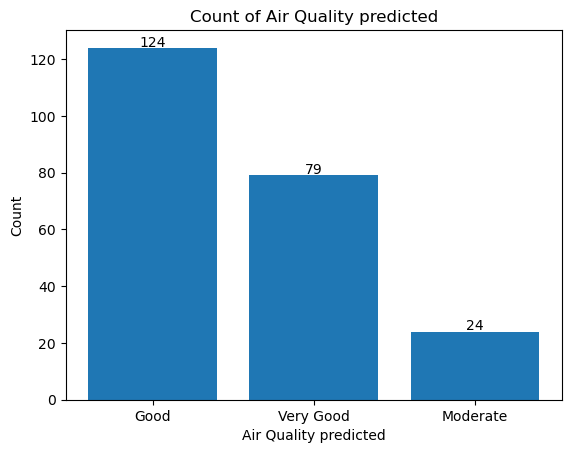

In [47]:
counts_predicted = new_df_2023['predicted_Air_Quality'].value_counts()
plt.bar(counts_predicted.index, counts_predicted.values)
for index, value in enumerate(counts_predicted.values):
    plt.text(index, value + 0.5, str(value), ha='center')
plt.xlabel('Air Quality predicted')
plt.ylabel('Count')
plt.title('Count of Air Quality predicted')
plt.show()

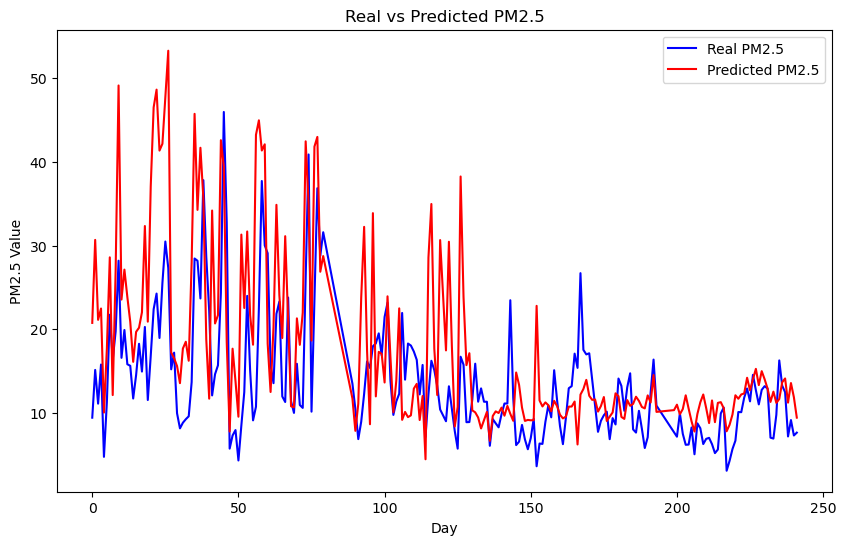

In [48]:
plt.figure(figsize=(10, 6))

plt.plot(df_2023.index, df_2023['pollution air PM2.5 [ug/m3]'], color='blue', label='Real PM2.5')

plt.plot(new_df_2023.index, new_df_2023['predicted_pm25'], color='red',  label='Predicted PM2.5')

plt.xlabel('Day') 
plt.ylabel('PM2.5 Value')
plt.title('Real vs Predicted PM2.5')
plt.legend()
plt.show()

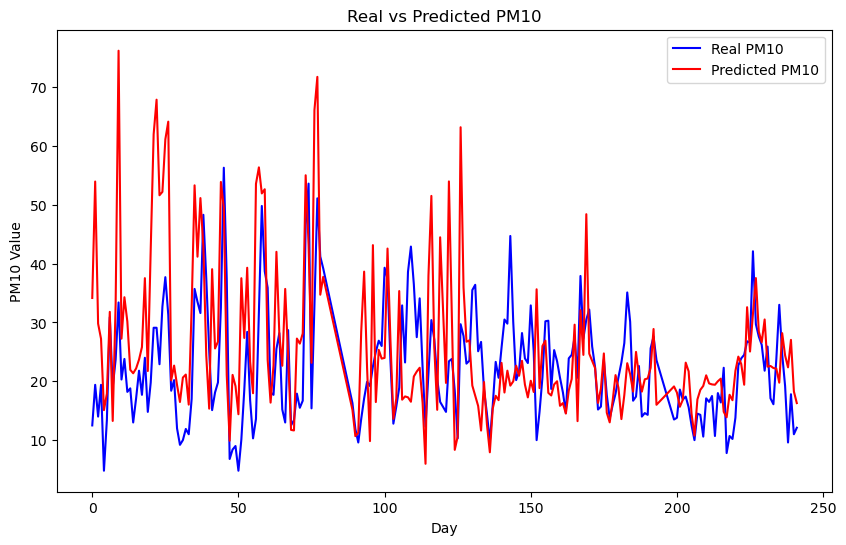

In [49]:
plt.figure(figsize=(10, 6))

plt.plot(df_2023.index, df_2023['pollution PM10 [ug/m3]'], color='blue', label='Real PM10')

plt.plot(new_df_2023.index, new_df_2023['predicted_pm10'], color='red',  label='Predicted PM10')

plt.xlabel('Day') 
plt.ylabel('PM10 Value')
plt.title('Real vs Predicted PM10')
plt.legend()
plt.show()

<font color="black" face="Times New Roman" size="6"><b> Results </b></font> 

In [50]:
rmse_10 = np.sqrt(mean_squared_error(ypm10, predict_10_2023))
r2_10 = r2_score(ypm10, predict_10_2023)
mae_10 = mean_absolute_error(ypm10, predict_10_2023)
print(f"RMSE: {rmse_10}")
print(f"MAE: {mae_10}")
print(f"R2: {r2_10}")

RMSE: 12.297857576641244
MAE: 8.970635054500093
R2: -0.6866867736449336


In [51]:
rmse_25 = np.sqrt(mean_squared_error(ypm25, predict_25_2023))
r2_25 = r2_score(ypm25, predict_25_2023)
mae_25 = mean_absolute_error(ypm25, predict_25_2023)
print(f"RMSE: {rmse_25}")
print(f"MAE: {mae_25}")
print(f"R2: {r2_25}")

RMSE: 8.79217862844231
MAE: 6.2792098820065245
R2: -0.44666197233472626
